## Imports and Set up


In [13]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# df = pd.read_csv("../data/flocking_250305.csv")
df = pd.read_csv("flocking_250409_v4.csv")
# df_1 = pd.read_csv("flocking_250409_v1.csv")
# df_2 = pd.read_csv("flocking_250409_v2.csv")
# df_3 = pd.read_csv("flocking_250409_v3.csv")
# df = pd.concat([df_1, df_2, df_3], ignore_index=True)
# print(f"Number of rows in df: {len(df)}")

Using device: cpu
Using device: cpu


In [14]:
df.head()

,Step,AgentID,Angle,Vision,Separation,CohereFactor,SeparateFactor,MatchFactor,NeighborDiffSum,NeighborInfo,run
0,0,1,4.038302,10,2,0.03,0.015,0.05,"[0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0
1,0,2,5.803319,10,2,0.03,0.015,0.05,"[0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0
2,0,3,1.369660,10,2,0.03,0.015,0.05,"[0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0
3,0,4,2.391038,10,2,0.03,0.015,0.05,"[0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0
4,0,5,5.571504,10,2,0.03,0.015,0.05,"[0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0


,Step,AgentID,Angle,Vision,Separation,CohereFactor,SeparateFactor,MatchFactor,NeighborDiffSum,NeighborInfo,run
0,0,1,4.038302,10,2,0.03,0.015,0.05,"[0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0
1,0,2,5.803319,10,2,0.03,0.015,0.05,"[0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0
2,0,3,1.369660,10,2,0.03,0.015,0.05,"[0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0
3,0,4,2.391038,10,2,0.03,0.015,0.05,"[0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0
4,0,5,5.571504,10,2,0.03,0.015,0.05,"[0, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",0


## Prepare Data

In [15]:
# df["NeighborDiffSum"] = df["NeighborDiffSum"].apply(lambda x: eval(x) if isinstance(x, str) else x)
df["NeighborInfo"] = df["NeighborInfo"].apply(lambda x: eval(x) if isinstance(x, str) else x)
df["Angle"] = df["Angle"].astype(float)

"""
group data according to each time step
"""
grouped = df.groupby("Step").agg(list)
# neighbor_diff_sum = np.array(grouped["NeighborDiffSum"].to_list())  # Shape: (num_steps, num_agents, 2)
neighbor_info = np.array(grouped["NeighborInfo"].to_list())  # Shape: (num_steps, num_agents, 2)
angles = np.array(grouped["Angle"].to_list()).reshape(len(grouped), len(grouped.iloc[0]["Angle"]), 1)  # Shape: (num_steps, num_agents, 1)

"""
this makes sure angle difference wraps correctly within [-pi. pi]
"""
def angle_difference(theta2, theta1):
    return np.arctan2(np.sin(theta2 - theta1), np.cos(theta2 - theta1))
delta_angle = np.zeros_like(angles)
delta_angle[1:] = angle_difference(angles[1:], angles[:-1]) # Shape: (num_steps, num_agents, 1)

grouped["deltaAngle"] = delta_angle.reshape(len(grouped), -1).tolist()

# X_train, X_test, y_train, y_test = train_test_split(neighbor_diff_sum, delta_angle, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(neighbor_info, delta_angle, test_size=0.2, random_state=42)

# to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

## For Debugging

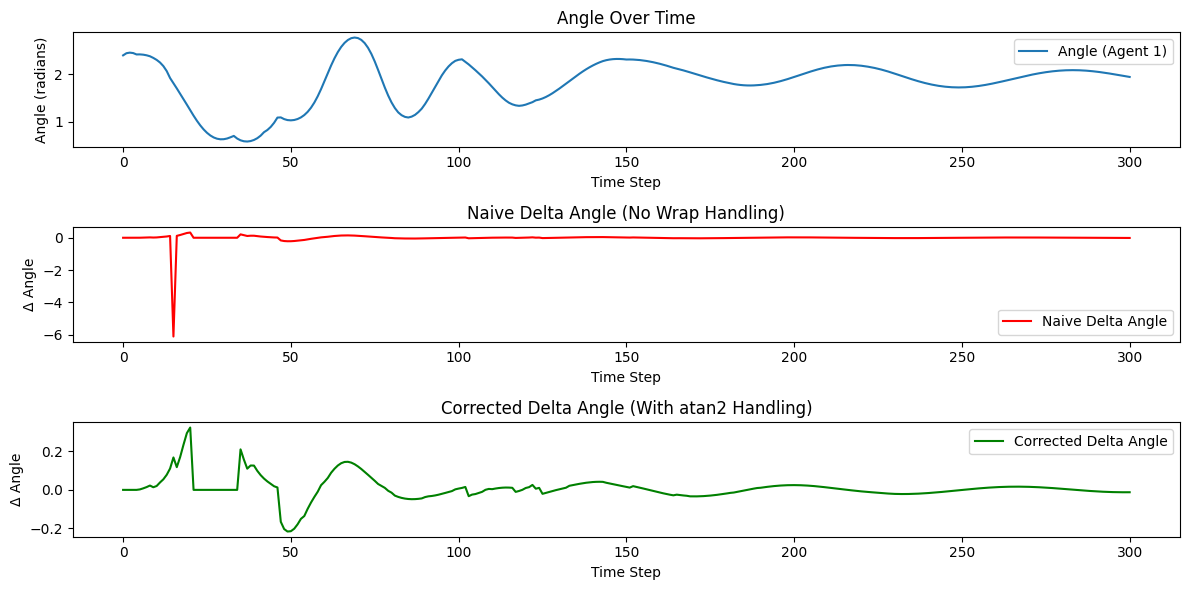

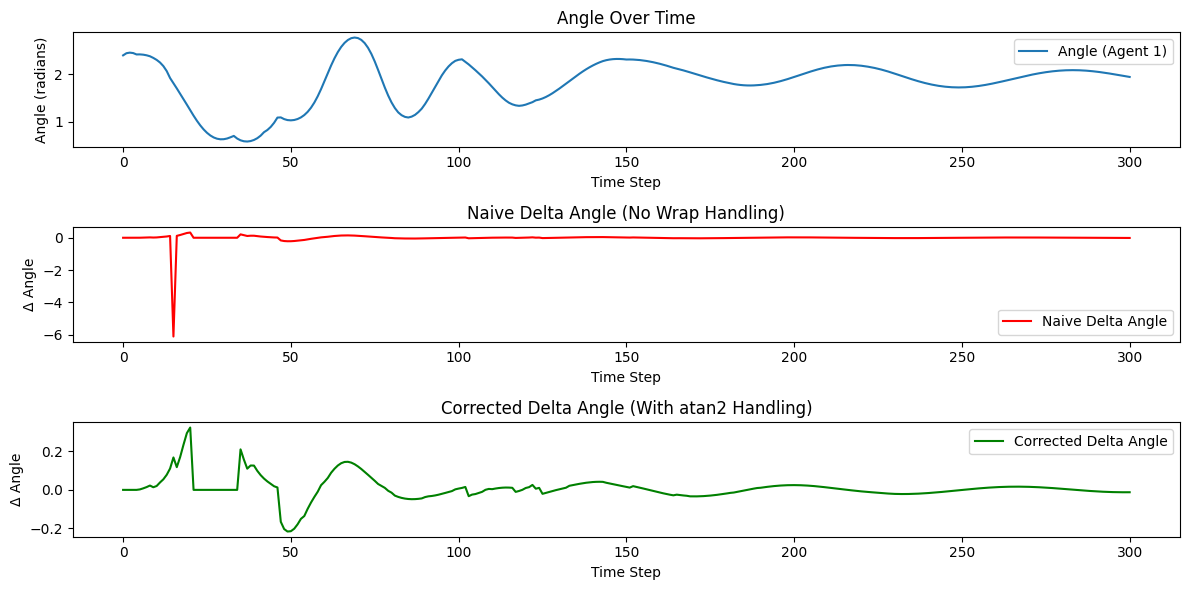

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Compute incorrect delta angles (naive subtraction)
naive_delta_angle = np.zeros_like(angles)
naive_delta_angle[1:] = angles[1:] - angles[:-1]

# Compute corrected delta angles (using atan2)
corrected_delta_angle = np.zeros_like(angles)
corrected_delta_angle[1:] = np.arctan2(np.sin(angles[1:] - angles[:-1]), np.cos(angles[1:] - angles[:-1]))

# Plot angles over time
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(angles[:, 3, 0], label="Angle (Agent 1)")
plt.xlabel("Time Step")
plt.ylabel("Angle (radians)")
plt.title("Angle Over Time")
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(naive_delta_angle[:, 1, 0], label="Naive Delta Angle", color="red")
plt.xlabel("Time Step")
plt.ylabel("Δ Angle")
plt.title("Naive Delta Angle (No Wrap Handling)")
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(corrected_delta_angle[:, 1, 0], label="Corrected Delta Angle", color="green")
plt.xlabel("Time Step")
plt.ylabel("Δ Angle")
plt.title("Corrected Delta Angle (With atan2 Handling)")
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
angles_df = pd.DataFrame(angles.reshape(len(grouped), -1))  # col: agent number; row: timestep
delta_angle_df = pd.DataFrame(delta_angle.reshape(len(grouped), -1))  # Each column is an agent's deltaAngle

In [18]:
angles_df.head(30)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,4.038302,5.803319,1.369660,2.391038,5.571504,5.449493,1.679502,1.487296,1.818456,1.367816,...,0.894012,2.400184,4.967643,5.359967,5.271930,0.980868,2.767447,2.379999,2.171715,5.713521
1,4.038302,5.803319,1.369660,2.436058,5.358983,5.449493,1.679502,1.487296,1.818456,1.367816,...,0.894012,2.400184,4.967643,5.319993,5.271930,0.691509,2.894324,2.379999,2.171715,5.656596
2,4.038302,5.803319,1.369660,2.447849,5.156265,5.577194,1.679502,1.487296,1.818456,1.367816,...,0.894012,2.400184,4.967643,5.229301,5.271930,0.496545,3.094730,2.379999,2.171715,5.643007
3,4.038302,5.803319,1.369660,2.438862,4.972505,5.642855,1.679502,1.487296,1.818456,1.367816,...,0.894012,2.400184,4.967643,5.065200,5.271930,0.309273,3.383714,2.379999,1.991991,5.650391
4,4.038302,5.803319,1.369660,2.410130,4.807304,5.764450,1.679502,1.487296,1.731134,1.367816,...,0.894012,2.400184,4.967643,4.805715,5.271930,0.134953,3.383714,2.379999,1.811734,5.677712
5,4.038302,5.805718,1.369660,2.411328,4.660168,5.868493,1.679502,1.487296,1.692883,1.192588,...,0.894012,2.400184,4.967643,4.805715,5.271930,6.261541,3.383714,2.379999,1.628962,5.723409
6,3.978850,5.813669,1.369660,2.405312,4.530924,5.960992,1.679502,1.487296,1.674179,1.112193,...,0.894012,2.400184,4.967643,4.805715,5.271930,6.126272,3.283410,2.383364,1.438128,5.785527
7,3.933417,5.828144,1.369660,2.392460,4.419986,6.047098,1.679502,1.487296,1.672987,1.050544,...,0.894012,2.400184,4.967643,4.805715,5.271930,6.014469,3.184597,2.363077,1.255236,5.858492
8,3.887924,5.850636,1.369660,2.372244,4.328427,6.131342,1.679502,1.487296,1.696881,1.002944,...,0.894012,2.400184,4.967643,4.805715,5.271930,5.926632,3.081153,2.322499,1.086238,5.920983
9,3.839292,5.864271,1.369660,2.337836,4.257834,6.202854,1.679502,1.487296,1.733059,0.966846,...,0.894012,2.400184,4.967643,4.805715,5.271930,5.860918,3.061953,2.264842,0.935107,5.974024


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,4.038302,5.803319,1.369660,2.391038,5.571504,5.449493,1.679502,1.487296,1.818456,1.367816,...,0.894012,2.400184,4.967643,5.359967,5.271930,0.980868,2.767447,2.379999,2.171715,5.713521
1,4.038302,5.803319,1.369660,2.436058,5.358983,5.449493,1.679502,1.487296,1.818456,1.367816,...,0.894012,2.400184,4.967643,5.319993,5.271930,0.691509,2.894324,2.379999,2.171715,5.656596
2,4.038302,5.803319,1.369660,2.447849,5.156265,5.577194,1.679502,1.487296,1.818456,1.367816,...,0.894012,2.400184,4.967643,5.229301,5.271930,0.496545,3.094730,2.379999,2.171715,5.643007
3,4.038302,5.803319,1.369660,2.438862,4.972505,5.642855,1.679502,1.487296,1.818456,1.367816,...,0.894012,2.400184,4.967643,5.065200,5.271930,0.309273,3.383714,2.379999,1.991991,5.650391
4,4.038302,5.803319,1.369660,2.410130,4.807304,5.764450,1.679502,1.487296,1.731134,1.367816,...,0.894012,2.400184,4.967643,4.805715,5.271930,0.134953,3.383714,2.379999,1.811734,5.677712
5,4.038302,5.805718,1.369660,2.411328,4.660168,5.868493,1.679502,1.487296,1.692883,1.192588,...,0.894012,2.400184,4.967643,4.805715,5.271930,6.261541,3.383714,2.379999,1.628962,5.723409
6,3.978850,5.813669,1.369660,2.405312,4.530924,5.960992,1.679502,1.487296,1.674179,1.112193,...,0.894012,2.400184,4.967643,4.805715,5.271930,6.126272,3.283410,2.383364,1.438128,5.785527
7,3.933417,5.828144,1.369660,2.392460,4.419986,6.047098,1.679502,1.487296,1.672987,1.050544,...,0.894012,2.400184,4.967643,4.805715,5.271930,6.014469,3.184597,2.363077,1.255236,5.858492
8,3.887924,5.850636,1.369660,2.372244,4.328427,6.131342,1.679502,1.487296,1.696881,1.002944,...,0.894012,2.400184,4.967643,4.805715,5.271930,5.926632,3.081153,2.322499,1.086238,5.920983
9,3.839292,5.864271,1.369660,2.337836,4.257834,6.202854,1.679502,1.487296,1.733059,0.966846,...,0.894012,2.400184,4.967643,4.805715,5.271930,5.860918,3.061953,2.264842,0.935107,5.974024


In [19]:
delta_angle_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.0,0.045020,-0.212521,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,-0.039974,0.0,-0.289359,0.126877,0.000000,0.000000,-0.056924
2,0.000000,0.000000,0.0,0.011791,-0.202718,0.127701,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,-0.090692,0.0,-0.194964,0.200406,0.000000,0.000000,-0.013590
3,0.000000,0.000000,0.0,-0.008987,-0.183760,0.065661,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,-0.164102,0.0,-0.187272,0.288985,0.000000,-0.179725,0.007384
4,0.000000,0.000000,0.0,-0.028732,-0.165201,0.121595,0.0,0.0,-0.087322,0.000000,...,0.0,0.0,0.0,-0.259485,0.0,-0.174320,0.000000,0.000000,-0.180256,0.027321
5,0.000000,0.002399,0.0,0.001198,-0.147136,0.104044,0.0,0.0,-0.038251,-0.175228,...,0.0,0.0,0.0,0.000000,0.0,-0.156598,0.000000,0.000000,-0.182772,0.045697
6,-0.059452,0.007951,0.0,-0.006016,-0.129243,0.092498,0.0,0.0,-0.018704,-0.080395,...,0.0,0.0,0.0,0.000000,0.0,-0.135269,-0.100304,0.003365,-0.190835,0.062119
7,-0.045433,0.014475,0.0,-0.012852,-0.110938,0.086106,0.0,0.0,-0.001191,-0.061649,...,0.0,0.0,0.0,0.000000,0.0,-0.111804,-0.098813,-0.020287,-0.182891,0.072965
8,-0.045493,0.022492,0.0,-0.020215,-0.091559,0.084244,0.0,0.0,0.023894,-0.047600,...,0.0,0.0,0.0,0.000000,0.0,-0.087836,-0.103444,-0.040578,-0.168998,0.062491
9,-0.048632,0.013635,0.0,-0.034409,-0.070593,0.071512,0.0,0.0,0.036178,-0.036098,...,0.0,0.0,0.0,0.000000,0.0,-0.065715,-0.019200,-0.057658,-0.151131,0.053041


,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.0,0.045020,-0.212521,0.000000,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,-0.039974,0.0,-0.289359,0.126877,0.000000,0.000000,-0.056924
2,0.000000,0.000000,0.0,0.011791,-0.202718,0.127701,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,-0.090692,0.0,-0.194964,0.200406,0.000000,0.000000,-0.013590
3,0.000000,0.000000,0.0,-0.008987,-0.183760,0.065661,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,-0.164102,0.0,-0.187272,0.288985,0.000000,-0.179725,0.007384
4,0.000000,0.000000,0.0,-0.028732,-0.165201,0.121595,0.0,0.0,-0.087322,0.000000,...,0.0,0.0,0.0,-0.259485,0.0,-0.174320,0.000000,0.000000,-0.180256,0.027321
5,0.000000,0.002399,0.0,0.001198,-0.147136,0.104044,0.0,0.0,-0.038251,-0.175228,...,0.0,0.0,0.0,0.000000,0.0,-0.156598,0.000000,0.000000,-0.182772,0.045697
6,-0.059452,0.007951,0.0,-0.006016,-0.129243,0.092498,0.0,0.0,-0.018704,-0.080395,...,0.0,0.0,0.0,0.000000,0.0,-0.135269,-0.100304,0.003365,-0.190835,0.062119
7,-0.045433,0.014475,0.0,-0.012852,-0.110938,0.086106,0.0,0.0,-0.001191,-0.061649,...,0.0,0.0,0.0,0.000000,0.0,-0.111804,-0.098813,-0.020287,-0.182891,0.072965
8,-0.045493,0.022492,0.0,-0.020215,-0.091559,0.084244,0.0,0.0,0.023894,-0.047600,...,0.0,0.0,0.0,0.000000,0.0,-0.087836,-0.103444,-0.040578,-0.168998,0.062491
9,-0.048632,0.013635,0.0,-0.034409,-0.070593,0.071512,0.0,0.0,0.036178,-0.036098,...,0.0,0.0,0.0,0.000000,0.0,-0.065715,-0.019200,-0.057658,-0.151131,0.053041


In [20]:
np.arctan2(-0.09105, 0.9958)

np.float64(-0.09118049177939738)

np.float64(-0.09118049177939738)

## Define Model

In [21]:
# define nn
hidden_size_1 = 16
hidden_size_2 = 8
hidden_size_3 = 4

model = nn.Sequential(
    nn.Linear(8, hidden_size_1),
    nn.ReLU(),
    nn.Linear(hidden_size_1, hidden_size_2),
    nn.ReLU(),
    nn.Linear(hidden_size_2, 1)
)

# define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Define Model

In [22]:
num_epochs = 500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor.view(-1, 8))
    loss = criterion(outputs, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/500], Loss: 0.0165
Epoch [20/500], Loss: 0.0106
Epoch [30/500], Loss: 0.0082
Epoch [40/500], Loss: 0.0069
Epoch [50/500], Loss: 0.0062
Epoch [60/500], Loss: 0.0056
Epoch [70/500], Loss: 0.0051
Epoch [80/500], Loss: 0.0047
Epoch [90/500], Loss: 0.0044
Epoch [100/500], Loss: 0.0041
Epoch [110/500], Loss: 0.0039
Epoch [120/500], Loss: 0.0037
Epoch [130/500], Loss: 0.0036
Epoch [140/500], Loss: 0.0035
Epoch [150/500], Loss: 0.0035
Epoch [160/500], Loss: 0.0034
Epoch [170/500], Loss: 0.0034
Epoch [180/500], Loss: 0.0033
Epoch [190/500], Loss: 0.0033
Epoch [200/500], Loss: 0.0033
Epoch [210/500], Loss: 0.0032
Epoch [220/500], Loss: 0.0032
Epoch [230/500], Loss: 0.0032
Epoch [240/500], Loss: 0.0032
Epoch [250/500], Loss: 0.0031
Epoch [260/500], Loss: 0.0031
Epoch [270/500], Loss: 0.0031
Epoch [280/500], Loss: 0.0031
Epoch [290/500], Loss: 0.0031
Epoch [300/500], Loss: 0.0031
Epoch [310/500], Loss: 0.0030
Epoch [320/500], Loss: 0.0030
Epoch [330/500], Loss: 0.0030
Epoch [340/500], Lo

## Evaluate the model

In [23]:
with torch.no_grad():
    y_pred = model(X_test_tensor.view(-1, 8))
    test_loss = criterion(y_pred, y_test_tensor.view(-1, 1))
    print(f'Test Loss: {test_loss.item():.4f}')
    print(y_pred)

Test Loss: 0.0030
tensor([[ 0.0082],
        [-0.0087],
        [-0.0134],
        ...,
        [ 0.0218],
        [ 0.0173],
        [-0.0081]])
Test Loss: 0.0031
tensor([[ 0.0152],
        [-0.0063],
        [-0.0032],
        ...,
        [ 0.0215],
        [ 0.0182],
        [-0.0707]])


## Save the model

In [24]:
torch.save(model, '20250305_v5_APR9run')